In [46]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [47]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/"
master_csv = data_dir + 'scnn1a-stp.csv'

enable_photoZ_interact = True
initialize_photoZ = False

# pilot control traces (5/20):
# 1_10, 1_14, 2_7

# Amp cutoff is slice/loc specific, see scnn1a-ppr.csv

In [48]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    # aPhz.click_normalize_2_array_max()

In [49]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,AmpCutoff
0,5/20/2024,1_1,NaN,L4,Rostral,2,1.1
1,5/20/2024,2_1,NaN,L4,Rostral,1,1.1


In [50]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': selected_zda_dir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': []}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
2 1 4
2 1 5
2 1 6
2 1 7


In [51]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract the entire trace for each ROI
initial_sweep = True
if enable_photoZ_interact:
    pa.alert("Starting trace extraction, set trace window to 0,2000 in Save/Load tab!")
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)
            if initial_sweep:
                #aPhz.change_baseline_correction(polynomial=False)
                initial_sweep = False

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

        # open zda files in order
        for i_zda_file in range(0, len(data_map[subdir][slic_id][loc_id]['zda_files'])):
            zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file]
            rec_id = zda_file.split(".")[0].split("_")[-1]

            print(slic_id, loc_id, " for recording",
                   zda_file.split("/")[-1])

            # save entire traces
            trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_" + rec_id + "freq.dat"
            is_loaded_zda_file = False
            if os.path.exists(trace_filename):
                print("\tAlready saved trace", trace_filename)
                is_loaded_zda_file = False
            elif enable_photoZ_interact:
                aPhz.open_zda_file(zda_file)
                time.sleep(13)
                print("\tSaving traces...")
                aPhz.save_current_traces(trace_filename, go_to_tab=True)
                print("\tSaved trace", trace_filename)
                is_loaded_zda_file = True

            if 'traces' not in data_map[subdir][slic_id][loc_id]:
                data_map[subdir][slic_id][loc_id]['traces'] = []

            data_map[subdir][slic_id][loc_id]['traces'].append(trace_filename)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24
1 1  for recording 01_01_04.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_04freq.dat
1 1  for recording 01_01_05.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_05freq.dat
1 1  for recording 01_01_06.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_06freq.dat
1 1  for recording 01_01_07.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_07freq.dat
1 1  for recording 01_01_08.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_08freq.dat
1 1  for recording 01_01_09.zda
	Saving traces...
	Saved trace C:/Users/jjudge3/Desktop/Data/mm

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_04freq.dat


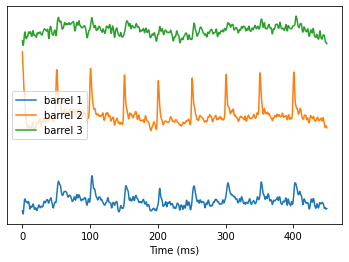

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_05freq.dat


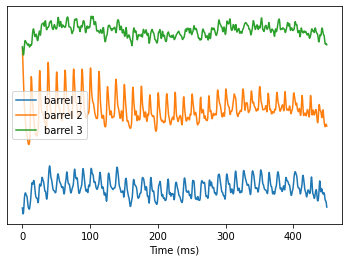

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_06freq.dat


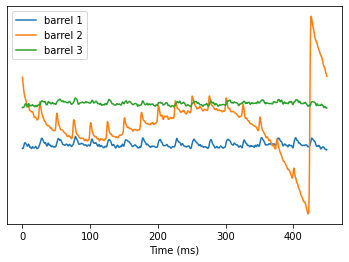

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_07freq.dat


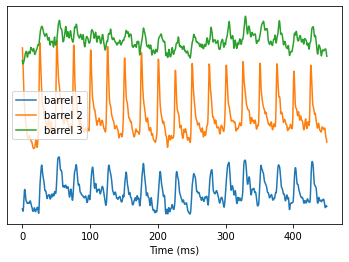

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_08freq.dat


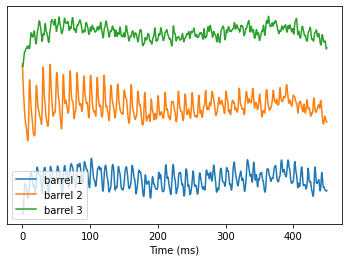

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_09freq.dat


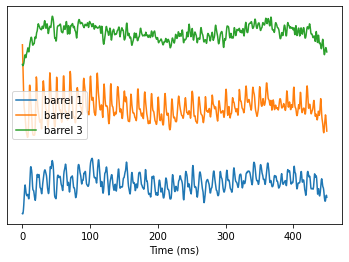

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_10freq.dat


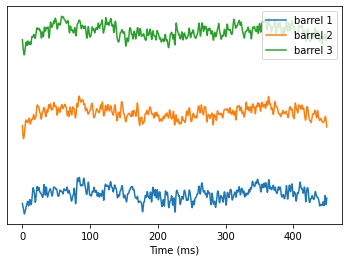

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_11freq.dat


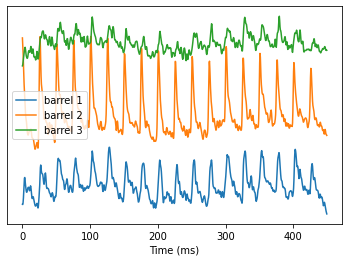

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_12freq.dat


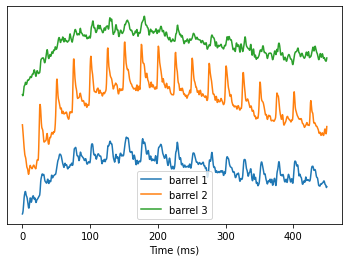

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_1_1_13freq.dat


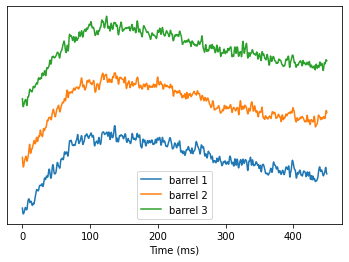

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_2_1_04freq.dat


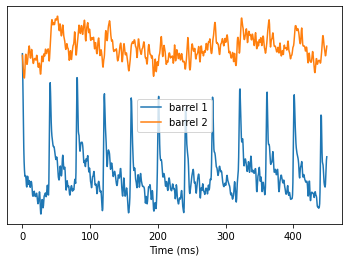

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_2_1_05freq.dat


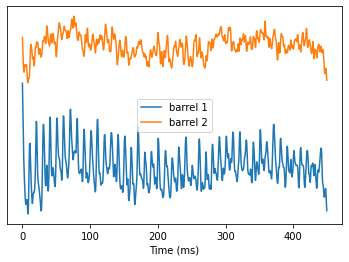

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_2_1_06freq.dat


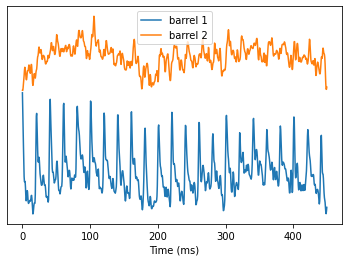

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/frequencies_STP/05-20-24/traces_2_1_07freq.dat


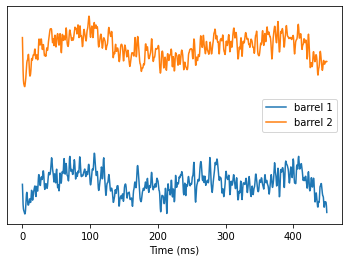

In [59]:
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# load traces and plot them
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            control_traces = []
            raw_traces = []
            stim_traces = []
            # open trace file
            for trace_filename in data_map[subdir][slic_id][loc_id]['traces']:
                print(trace_filename)
                trace = read_dat_trace_file(trace_filename)
                # print(data_arr)
                fig, ax = plt.subplots()
                for i in range(1, len(trace.columns)):
                    t = np.linspace(0, len(trace.iloc[:, i]) / 2, len(trace.iloc[:, i]))
                    ax.plot(t, trace.iloc[:, i] + i, label="barrel " + str(i))
                ax.set_yticks([])
                ax.legend()
                ax.set_xlabel("Time (ms)")
                plt.show()
                

In [ ]:
control_match_dist_cutoff = 0.2  # if STDEV of subtraction is greater than this, skip
plot_traces = True

task = "review"  # review or export

# review: see all traces, annotated
if task == 'review':
    remove_filters = True
    export_movie = False
    annotate_traces = True

# export: save filtered traces to gif
if task == 'export':
    remove_filters = False
    export_movie = True
    annotate_traces = False

'''Now load traces and perform summation decomposition by 
subtracting the control trace from the paired-pulse trace. '''


df_lists = {'IPI': [], 'ROI': [], 'Medial Dir': [], 'Stim Layer': [], 'Caudal Rostral': [], 'Home Barrel': [],
            'Date': [], 'Slice_Loc': [], 'PPR': [],
            'First Max Composed': [], 'Second Max Composed': [],
            'First Max Controlled': [], 'Second Max Controlled': [], 'PPR Composed': []}


dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            amp_cutoff = float(master_df[(master_df['Date'] == date) & (master_df['Slice_Loc'] == slic_loc_id)]['AmpCutoff'].item())
            print(date, slic_loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            movies = {}

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                print("\tIPI:", ipi)

                # load traces and control traces for this ipi
                trace_filename = data_map[subdir][slic_id][loc_id][ipi]['trace']
                control_trace_filename = data_map[subdir][slic_id][loc_id][ipi]['control_trace']
                trace_baselined_filename = data_map[subdir][slic_id][loc_id][ipi]['trace_baselined']
                trace = read_dat_trace_file(trace_filename)
                control_trace = read_dat_trace_file(control_trace_filename)
                baselined_trace = read_dat_trace_file(trace_baselined_filename)

                # show both traces and their subtraction
                trace_sub = trace - control_trace
                trace_sub = trace_sub.drop(columns=['Pt'])
                trace_sub = trace_sub.dropna()

                # calculate dist from zero of subtracted trace before second stim
                trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()

                # calculate maxAmp of subtracted trace in measure window (356 - 450)
                trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                # perform baseline subtraction on control trace
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace[(control_trace.index > first_stim_start) 
                                                        & (control_trace.index < first_stim_start + 104)]['Corrected_'+roi].max()
                
                # extract first and second maxAmp of baselined_trace
                first_max_baselined = baselined_trace[(baselined_trace.index > first_stim_start) & 
                                                      (baselined_trace.index < 345)].max()
                second_max_baselined = baselined_trace[(baselined_trace.index > 356) & (baselined_trace.index < 550)].max()

                for roi in control_trace.columns:
                    if not ('ROI' in roi and len(roi) == 4):
                        continue

                    n_roi = int(roi[3])

                    # filters
                    if not remove_filters:
                        if trace_sub_dist[roi] > control_match_dist_cutoff:  # skip if magnitude of subtraction is too high
                            continue
                        if trace_sub_max[roi] < amp_cutoff and control_trace_max[roi] < amp_cutoff:  # skip if maxAmp of subtraction is too low
                            continue
                    if plot_traces:
                        plt.rcParams["figure.figsize"] = 10, 3
                        plt.rcParams.update({'font.size': 12})
                        fig, axes = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[4, 1]})
                        axes[0].plot(trace[roi], c='tab:orange', label= roi + ' raw')
                        axes[0].plot(control_trace[roi], 'k--', label= roi + ' control', alpha=0.5)
                        axes[0].plot(trace_sub[roi], c='tab:blue', label= roi + ' subtraction = raw - control')
                        axes[0].plot(control_trace_corrected[roi], c='tab:blue', label= roi + ' control w/ polyfit', alpha=0.5)

                        ceiling_1 = 1.2 * trace[roi].max()
                        axes[0].plot(baselined_trace[roi] + ceiling_1, c='tab:green', label= roi + ' raw w/ polyfit', alpha=0.5)
                        axes[0].annotate("Mean dist:\n" + str(trace_sub_dist[roi])[:5], 
                                        xy=(100, 1), fontsize=8, color='tab:blue')
                        if annotate_traces:
                            # annotate maxAmp of subtracted trace
                            axes[0].annotate("2nd maxAmp: " + str(trace_sub_max[roi])[:5], xy=(450, 3), fontsize=8, color='tab:blue')
                            # annotate maxAmp of control trace
                            axes[0].annotate("1st maxAmp: " + str(control_trace_max[roi])[:5], xy=(200, 5), fontsize=8, color='tab:blue')

                            # annotate maxAmp of baselined trace
                            axes[0].annotate("2nd maxAmp: " + str(second_max_baselined[roi])[:5], xy=(450, 3+ceiling_1), 
                                            fontsize=8, color='tab:green')
                            # annotate maxAmp of baselined trace
                            axes[0].annotate("1st maxAmp: " + str(first_max_baselined[roi])[:5], xy=(200, 5+ ceiling_1),
                                            fontsize=8, color='tab:green')

                        h, l = axes[0].get_legend_handles_labels()
                        axes[1].legend(h, l, borderaxespad=0)
                        axes[1].axis('off')
                        axes[0].set_yticks([])
                        plt.title(date + " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                        if export_movie:
                            png_filename = subdir + "/Plot-traces" + slic_loc_id + "_IPI" + str(ipi) + "_" + roi + ".png"
                        plt.savefig(png_filename, dpi=300, bbox_inches='tight')
                        plt.show()
                        if roi not in movies:
                            movies[roi] = {}
                        movies[roi][ipi] = png_filename


                    # traces not filtered out: calculate PPR and save metadata to snr_dfs
                    ppr = 0
                    if control_trace_max[roi] != 0:
                        ppr = trace_sub_max[roi] / control_trace_max[roi]

                    # baselined maxamps to composed PPR
                    ppr_composed = 0
                    if first_max_baselined[roi] != 0:
                        ppr_composed = second_max_baselined[roi] / first_max_baselined[roi]

                    df_lists['IPI'].append(ipi)
                    df_lists['ROI'].append(n_roi)
                    df_lists['Medial Dir'].append(medial_dir)
                    df_lists['Stim Layer'].append(stim_layer)
                    df_lists['Caudal Rostral'].append(caudal_rostral)
                    df_lists['Home Barrel'].append(home_barrel)
                    df_lists['Date'].append(date)
                    df_lists['Slice_Loc'].append(slic_loc_id)
                    df_lists['PPR'].append(ppr)
                    df_lists['First Max Composed'].append(first_max_baselined[roi])
                    df_lists['Second Max Composed'].append(second_max_baselined[roi])
                    df_lists['First Max Controlled'].append(control_trace_max[roi])
                    df_lists['Second Max Controlled'].append(trace_sub_max[roi])
                    df_lists['PPR Composed'].append(ppr_composed)
            
            # save movies
            if export_movie:
                for roi in movies:
                    roi_movie = movies[roi]
                    ipis_keys = list(roi_movie.keys())
                    ipis_keys.sort()
                    roi_movie = [roi_movie[ipi] for ipi in ipis_keys]
                    roi_movie = [imageio.imread(img) for img in roi_movie]
                    gif_filename = subdir + "/IPIs_" + slic_loc_id + roi + ".gif"
                    imageio.mimsave(gif_filename, roi_movie, fps=5)
                    print("created movie", gif_filename)
            



5/20/2024 1_1
5/20/2024 2_1


In [ ]:
# create dataframe from df_lists
df = pd.DataFrame.from_dict(df_lists)
numeric_cols = ['IPI', 'ROI', 'PPR', 'Home Barrel']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfs.append(df)
csv_filename = 'scnn1a-ppr-output.csv'
df.to_csv(data_dir + csv_filename, index=False)
df

,IPI,ROI,Medial Dir,Stim Layer,Caudal Rostral,Home Barrel,Date,Slice_Loc,PPR,First Max Composed,Second Max Composed,First Max Controlled,Second Max Controlled,PPR Composed
0,90,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.771491,1.062330,0.955963,1.172716,0.90474,0.899874
1,50,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.763385,0.950385,1.031360,1.222292,0.93308,1.085202
2,20,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.721470,1.044470,1.173150,1.245790,0.89880,1.123201
3,30,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.851797,1.069790,1.073950,1.113857,0.94878,1.003889
4,80,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.742886,1.221580,1.054310,1.155050,0.85807,0.863071
5,110,2,NaN,L4,Rostral,2,5/15/2024,1_1,0.977048,1.268210,1.113790,1.204761,1.17711,0.878238
6,60,2,NaN,L4,Rostral,2,5/15/2024,2_1,0.835586,1.679290,1.598200,1.845997,1.54249,0.951712
7,50,2,NaN,L4,Rostral,2,5/15/2024,2_1,0.868730,1.723480,1.794990,1.846269,1.60391,1.041492
8,70,2,NaN,L4,Rostral,2,5/15/2024,2_1,0.784113,1.772450,1.675890,1.867946,1.46468,0.945522
9,30,2,NaN,L4,Rostral,2,5/15/2024,2_1,0.729916,1.690980,1.859030,1.882832,1.37431,1.099380


In [ ]:
for date in df['Date'].unique():
    print(df[df['Date'] == date]['Slice_Loc'].unique())

['1_1' '2_1']
['1_1' '4_1']


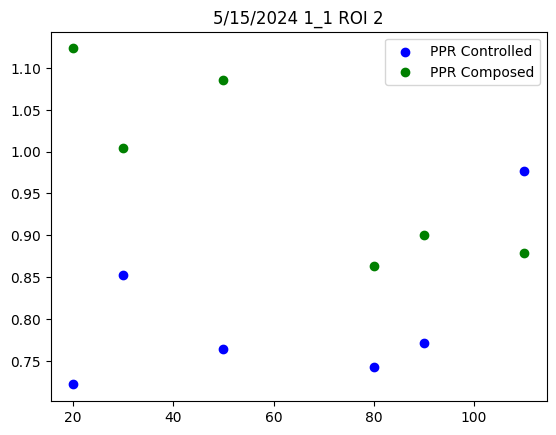

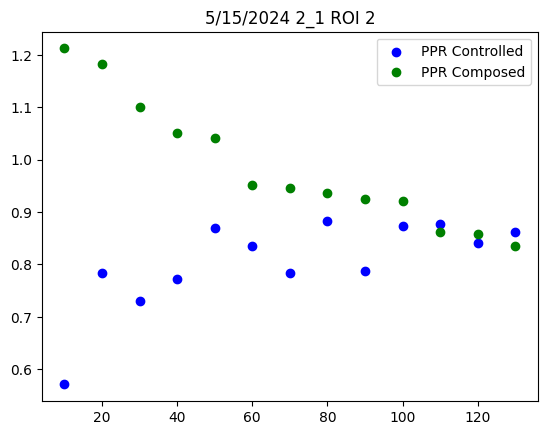

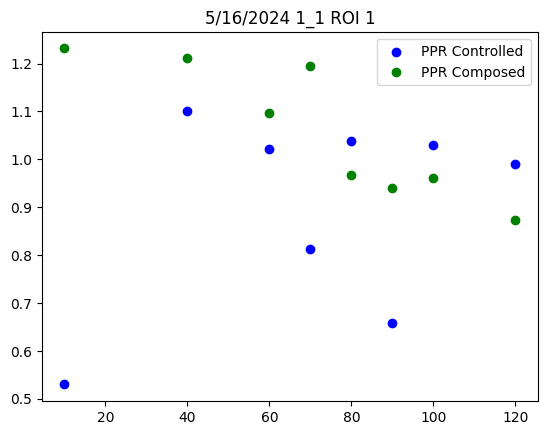

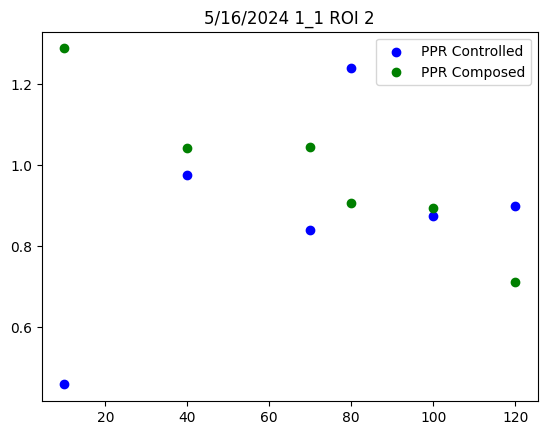

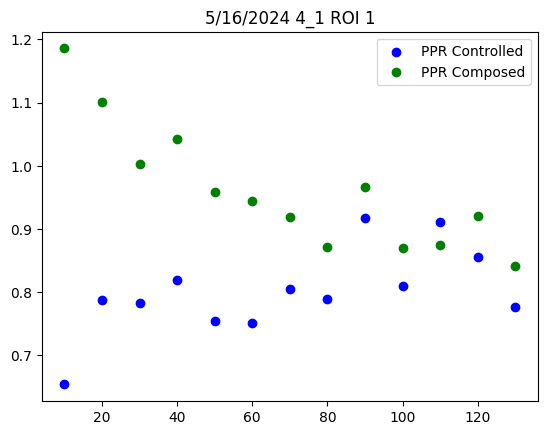

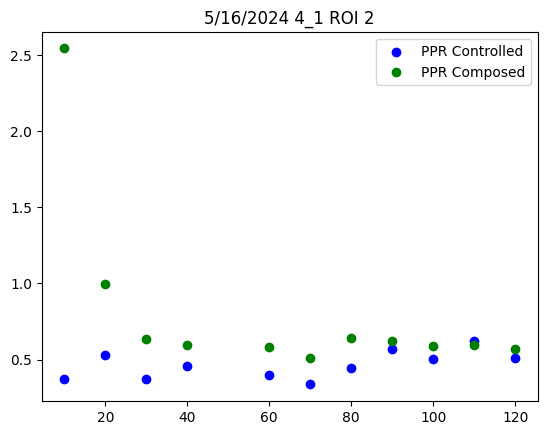

In [ ]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
plt.rcParams.update(plt.rcParamsDefault)
for date in df['Date'].unique():
    pfs_date = df[df["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():

            # plot PPR
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'], label='PPR Controlled', c = 'b')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))

            # plot PPR Composed
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR Composed'], label='PPR Composed', c='g')
            plt.legend()

            plt.show()
            '''plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()'''

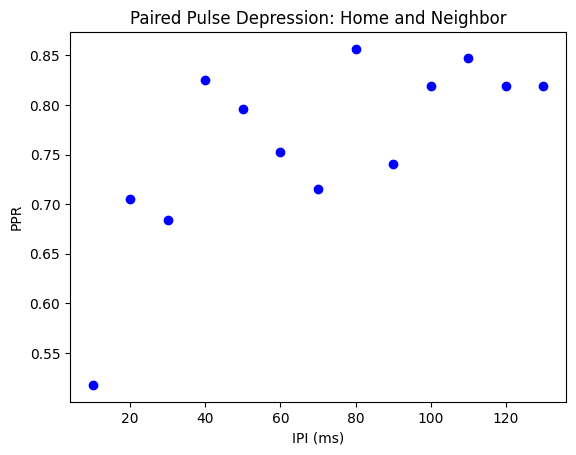

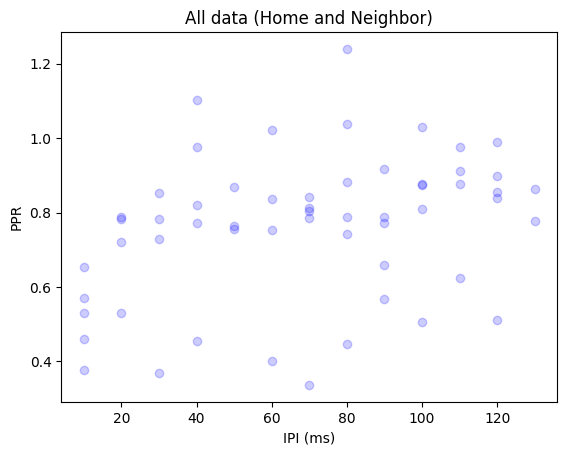

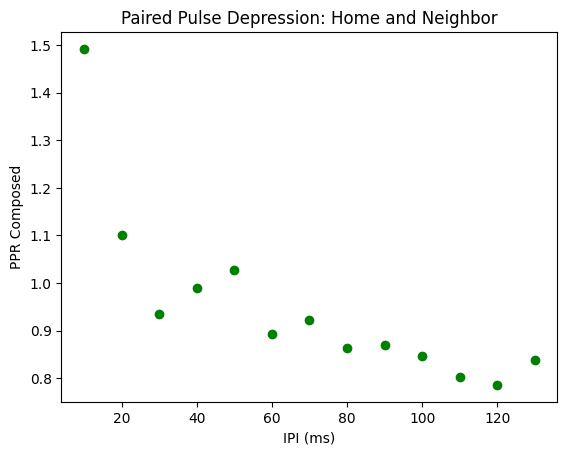

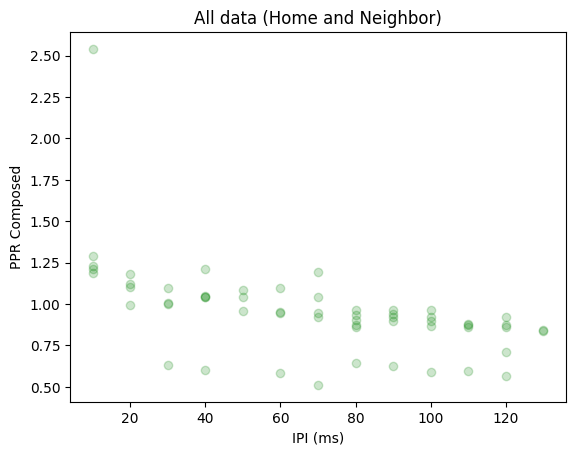

In [ ]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = df[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(df['IPI'], df[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

     PPR
IPI     
10     3
20     3
30     3
40     3
50     3
60     3
70     3
80     4
90     4
100    3
110    3
120    3
130    2
i= 0
10
p_val for IPI 20 : 0.9894916253555484
p_val for IPI 30 : 0.9919562409422645
p_val for IPI 40 : 0.9598340358433537
p_val for IPI 50 : 0.9923963079368998
p_val for IPI 60 : 0.9740373668239829
p_val for IPI 70 : 0.9884242357937114
p_val for IPI 80 : 0.9917411706659411
p_val for IPI 90 : 0.9860298612262527
p_val for IPI 100 : 0.9892587623557784
p_val for IPI 110 : 0.9988161456188718
p_val for IPI 120 : 0.996046576907927
p_val for IPI 130 : 0.9805740714138674
[None, None, None, None, None, None, None, None, None, None, None, None, None]


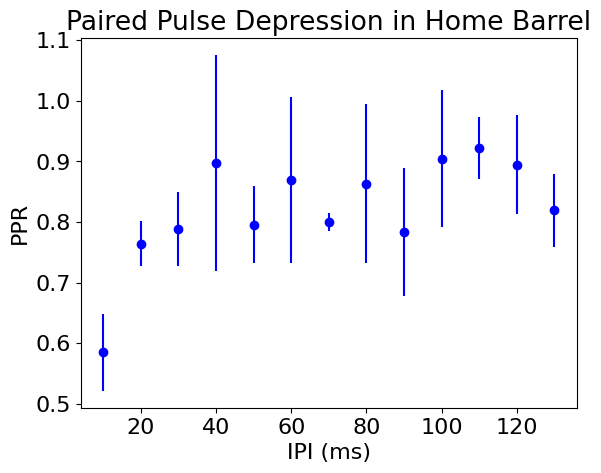

     PPR
IPI     
10     2
20     1
30     1
40     2
60     1
70     2
80     2
90     1
100    2
110    1
120    2
i= 1
110
p_val for IPI 10 : nan
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 120 : nan
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, dd

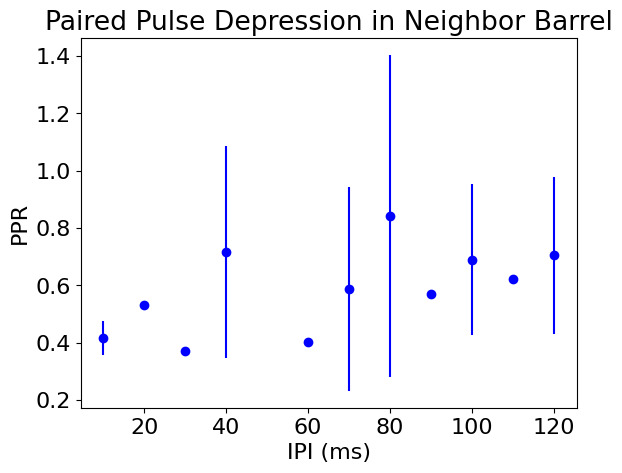

     PPR Composed
IPI              
10              3
20              3
30              3
40              3
50              3
60              3
70              3
80              4
90              4
100             3
110             3
120             3
130             2
i= 0
10
p_val for IPI 20 : 0.03586867949781797
p_val for IPI 30 : 0.01000566166948343
p_val for IPI 40 : 0.09035323254908449
p_val for IPI 50 : 0.014156750137542211
p_val for IPI 60 : 0.02106028726000711
p_val for IPI 70 : 0.08066823710424895
p_val for IPI 80 : 0.0001315536252685636
p_val for IPI 90 : 1.7514733044274047e-05
p_val for IPI 100 : 0.0011565027474031773
p_val for IPI 110 : 0.00022155540938851415
p_val for IPI 120 : 0.0001362813020891616
p_val for IPI 130 : 0.0003601290092471536
[None, '*', '*', None, '*', '*', None, '***', '***', '**', '***', '***', '***']


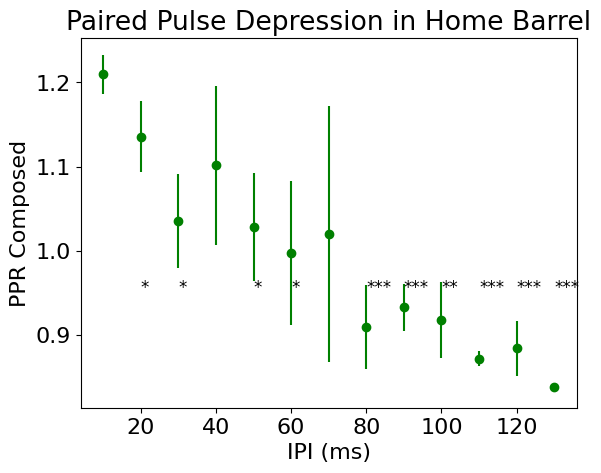

     PPR Composed
IPI              
10              2
20              1
30              1
40              2
60              1
70              2
80              2
90              1
100             2
110             1
120             2
i= 1
10
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : 0.154591434203591
p_val for IPI 60 : nan
p_val for IPI 70 : 0.14610056958706122
p_val for IPI 80 : 0.15490774956329223
p_val for IPI 90 : nan
p_val for IPI 100 : 0.1494307947617099
p_val for IPI 110 : nan
p_val for IPI 120 : 0.1436414516647506
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, dd

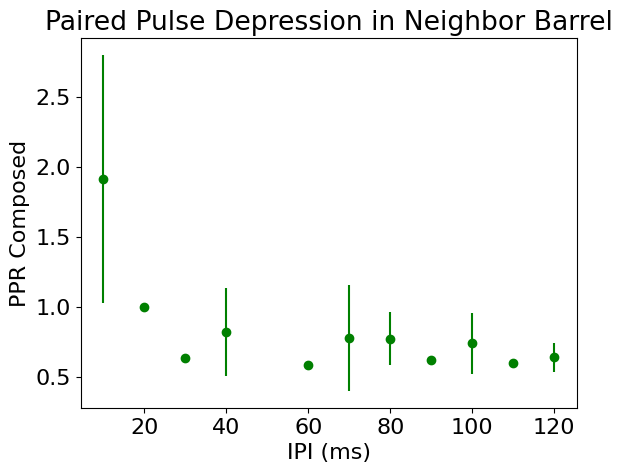

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # one-sided t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            

        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        for j, txt in enumerate(significance_levels):
            plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        plt.ylabel(y_label)
        plt.show()
        i += 1

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 10 : 0.03728833282635659
p_val for IPI 20 : nan
p_val for IPI 30 : nan
p_val for IPI 40 : 0.30615617880816554
p_val for IPI 60 : nan
p_val for IPI 70 : 0.2776649161057324
p_val for IPI 80 : 0.48373082732044037
p_val for IPI 90 : nan
p_val for IPI 100 : 0.22084809144700318
p_val for IPI 110 : nan
p_val for IPI 120 : 0.25097028460165066
['*', None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, dd

In [ ]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = df.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b']]: # , ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        #plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


UndefinedVariableError: name 'Pulse' is not defined

In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                            skip_width=skip_width)
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            #measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            measure_window_start = 356
                            if i_pulse == 1:
                                measure_window_start -= ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)


                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/better_baseline/04-24-24
2 1 IPI: 70 ms for recording 02_01_01.zda
2 1 IPI: 10 ms for recording 02_01_02.zda
2 1 IPI: 20 ms for recording 02_01_03.zda
2 1 IPI: 90 ms for recording 02_01_04.zda
2 1 IPI: 60 ms for recording 02_01_05.zda
2 1 IPI: 40 ms for recording 02_01_06.zda
2 1 IPI: 100 ms for recording 02_01_07.zda
2 1 IPI: 130 ms for recording 02_01_08.zda
2 1 IPI: 110 ms for recording 02_01_09.zda
2 1 IPI: 50 ms for recording 02_01_10.zda
2 1 IPI: 30 ms for recording 02_01_11.zda
2 1 IPI: 80 ms for recording 02_01_12.zda
2 1 IPI: 120 ms for recording 02_01_13.zda
3 1 IPI: 120 ms for recording 03_01_02.zda
3 1 IPI: 130 ms for recording 03_01_03.zda
3 1 IPI: 80 ms for recording 03_01_04.zda
3 1 IPI: 40 ms for recording 03_01_05.zda
3 1 IPI: 90 ms for recording 03_01_06.zda
3 1 IPI: 70 ms for recording 03_01_07.zda
3 1 IPI: 30 ms for recording 03_01_08.zda
3 1 IPI: 60 ms for recording 03_01_09.zda
3 1 IPI: 50 ms for recording 03_

In [ ]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = []
pphw_hist = []
ppl_hist = []
amp_cutoff = 1
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map[amp_arr1 < amp_cutoff] = 0
                '''if np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 2)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(ppr_map > 1, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''

                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            ppr_hist.append(ppr_map[i, j])


<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-216-bd3863ed5157>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: divide by zero encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-234-1c0c101795ff>:46: RuntimeWarning: invalid value encountered in true_divide
  ppr_map = amp_arr2 / amp_arr1


           params       sigma
mu1      0.810105    4.321200
sigma1   0.124662    1.083099
A1       6.434943  246.493731
mu2      0.920718    0.156720
sigma2   0.103106    0.086940
A2      42.080217  328.991449


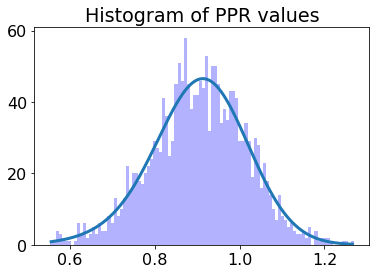

In [ ]:

# plot histogram of PPR values
y,x,_=plt.hist(ppr_hist, bins=100, color='b', alpha=0.3)
plt.title("Histogram of PPR values")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (0.7, .02, 25, 0.8, .02, 15)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
#...and individual Gauss curves
'''plt.plot(x_fit, gauss(x_fit, *params[:3]), 
         color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
plt.plot(x_fit, gauss(x_fit, *params[3:]), 
         color='tab:green', lw=3, ls=":", label='mean PPR: 0.82 ± 0.07')'''
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
#plt.legend(loc = 'upper left')
#plt.ylim(0, 17)
#plt.xlim(0.2, 1.2)
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 